<a href="https://colab.research.google.com/github/immelstorun/Angles-detection-with-YOLO/blob/main/M87_angles_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет!
Команда M87 представляет свое решение задачи по расхождению угла строп.
Мы обучили нейросеть YOLOv8s pose на своем датасете (гпнефть), который подготовили из видеоряда. Разметку keypoints делали в сервисе робофлоу, отттуда же экспортировали датасет для Yolo.

Обучали на 600 эпохах на 15 Гб ГПУ. https://github.com/immelstorun/Angles-detection-with-YOLO

In [17]:
import numpy as np
import math
import os
import random

import cv2
import numpy as np
from matplotlib import pyplot as plt

#!pip install ultralytics==8.0.196 -q

import ultralytics
print(ultralytics.checks())

from ultralytics import YOLO
from IPython.display import display, Image
from PIL import Image
#!nvidia-smi

Ultralytics YOLOv8.2.2  Python-3.8.19 torch-2.2.2 CUDA:0 (NVIDIA GeForce RTX 3080 Ti, 12288MiB)
Setup complete  (8 CPUs, 20.0 GB RAM, 100.9/119.2 GB disk)
None


## Train a YOLOv8 Keypoint Detection Model


In [5]:
model = YOLO('yolov8s-pose.pt')
results = model.train(data=f"data/labeled/v4/data.yaml", epochs=1, imgsz=640)

New https://pypi.org/project/ultralytics/8.2.3 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.2  Python-3.8.19 torch-2.2.2 CUDA:0 (NVIDIA GeForce RTX 3080 Ti, 12288MiB)
engine\trainer: task=pose, mode=train, model=yolov8s-pose.pt, data=data/labeled/v4/data.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False

train: Scanning G:\github\Angles-detection-with-YOLO\data\labeled\v4\train\labels... 128 images, 0 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<00:00, 894.55it/s]

train: New cache created: G:\github\Angles-detection-with-YOLO\data\labeled\v4\train\labels.cache



val: Scanning G:\github\Angles-detection-with-YOLO\data\labeled\v4\valid\labels... 36 images, 0 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<00:00, 705.10it/s]

val: New cache created: G:\github\Angles-detection-with-YOLO\data\labeled\v4\valid\labels.cache


Plotting labels to runs\pose\train7\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\pose\train7
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


        1/1      4.37G       3.03       4.75      0.734      7.087      2.919         28        640: 100%|██████████| 8/8 [00:27<00:00,  3.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


                   all         36         36      0.011      0.944     0.0513     0.0192       0.01      0.861     0.0473    0.00959

1 epochs completed in 0.010 hours.
Optimizer stripped from runs\pose\train7\weights\last.pt, 23.1MB
Optimizer stripped from runs\pose\train7\weights\best.pt, 23.1MB

Validating runs\pose\train7\weights\best.pt...
Ultralytics YOLOv8.2.2  Python-3.8.19 torch-2.2.2 CUDA:0 (NVIDIA GeForce RTX 3080 Ti, 12288MiB)
YOLOv8s-pose summary (fused): 187 layers, 11413344 parameters, 0 gradients, 29.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


                   all         36         36     0.0111      0.944     0.0514     0.0196     0.0101      0.861     0.0479    0.00968
Speed: 1.0ms preprocess, 3.2ms inference, 0.0ms loss, 6.0ms postprocess per image
Results saved to runs\pose\train7


## Test the Keypoint Detection Model

In [8]:
# test our keypoint detection model on an image
model = YOLO('runs/pose/train7/weights/best.pt')

data/labeled/v4/test/images\114_jpg.rf.691e2c9f90a170bd1107406a350e1dd5.jpg

image 1/1 g:\github\Angles-detection-with-YOLO\data\labeled\v4\test\images\114_jpg.rf.691e2c9f90a170bd1107406a350e1dd5.jpg: 640x640 (no detections), 100.0ms
Speed: 10.0ms preprocess, 100.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)
tensor([], device='cuda:0', size=(1, 0, 2))


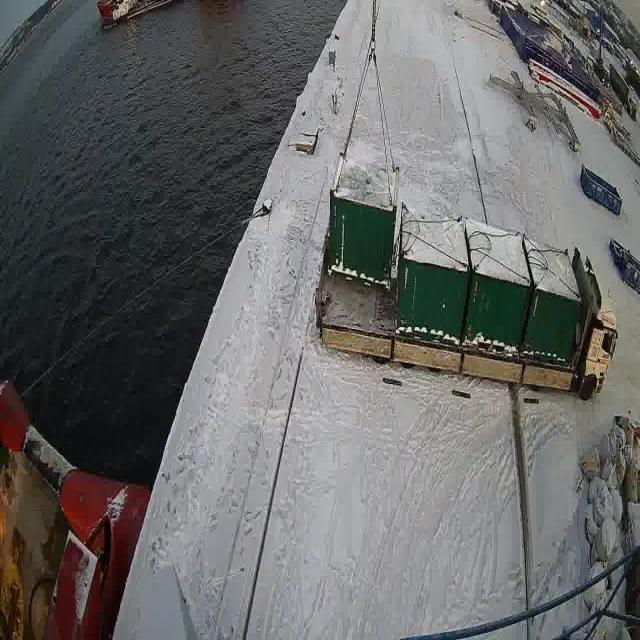

In [13]:
# We can visualize our keypoints
random_file = random.choice(os.listdir(f"data/labeled/v4/test/images"))
image_path = os.path.join("data/labeled/v4/test/images", random_file)

print(image_path)

results = model(image_path)

print(results[0].keypoints.xy)

r = results[0]
im_array = r.plot()  # plot a BGR numpy array of predictions
im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
display(im)

Our model successfully identified keypoints in the image.

## Calculate Keypoint Angle


In [14]:
results[0].keypoints.xy[0]

tensor([], device='cuda:0', size=(0, 2))

In [15]:
# results уже содержат нужный тензор
keypoints = results[0].keypoints.xy[0]

# Переносим тензор на CPU и преобразуем его в список
keypoints_list = keypoints.cpu().numpy().tolist()

# Теперь keypoints_list содержит координаты точек в виде списка списков:
# [
#   [344.5808, 62.5307],
#   [368.8192, 194.1467],
#   ...
# ]
keypoints_list

[]

In [ ]:
# Cписок координат keypoints_list

# 1. Находим вершину (самую верхнюю точку)
vertex = min(keypoints_list, key=lambda x: x[1])

# 2. Находим две основные точки, расположенные по горизонтали
# Отбрасываем вершину из поиска
base_points = [point for point in keypoints_list if point != vertex]

# Находим ближайшие по горизонтали точки к средней точке по оси X
mid_x = sum(point[0] for point in base_points) / len(base_points)
base_points = sorted(base_points, key=lambda x: abs(x[0] - mid_x))

# Берем две ближайшие к средней точке
point1, point2 = base_points[:2]

# 3. Расчет угла между прямыми
def angle_between_points(p1, p2, p3):
    # Векторы p1p2 и p1p3
    p1p2 = np.array([p2[0] - p1[0], p2[1] - p1[1]])
    p1p3 = np.array([p3[0] - p1[0], p3[1] - p1[1]])

    # Скалярное произведение векторов
    dot_product = np.dot(p1p2, p1p3)

    # Длины векторов
    len_p1p2 = np.linalg.norm(p1p2)
    len_p1p3 = np.linalg.norm(p1p3)

    # Угол между векторами в радианах
    angle = math.acos(dot_product / (len_p1p2 * len_p1p3))

    # Угол в градусах
    angle_degrees = math.degrees(angle)

    return angle_degrees

# Рассчитываем угол
angle = angle_between_points(vertex, point1, point2)

print(f"The angle between the lines is: {angle} degrees")

In [20]:
# Весь хакатон начинался с этого прототипа:)

def angle_between_points(p0, p1, p2):
    a = np.array(p0) - np.array(p1)
    b = np.array(p2) - np.array(p1)
    cosine_angle = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

# Set a random seed for reproducibility
#np.random.seed(5)

# Create a white image
width, height = 640, 640
image = np.ones((height, width, 3), dtype=np.uint8) * 255

# Generate coordinates for a random triangle
vertices = np.random.randint(100, 300, size=(3, 2))

# Draw the triangle
cv2.polylines(image, [vertices], isClosed=True, color=(0, 0, 0), thickness=2)

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding
_, threshold_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(threshold_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
contour_image = image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 3)

# Find the triangle among contours and calculate the top angle
for contour in contours:
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    if len(approx) == 3:
        vertices = approx.reshape(-1, 2)
        vertices = vertices[np.argsort(vertices[:, 1])]

        top_angle = angle_between_points(vertices[1], vertices[0], vertices[2])
        print(f"Top vertex angle of the triangle: {top_angle:.2f} degrees")
        break
else:
    print("Triangle not found")

# Convert BGR images to RGB for displaying in matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
contour_image_rgb = cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB)

# Display the images side by side using matplotlib
fig, axs = plt.subplots(1, 2, figsize=(6, 4))

# Display the original image
axs[0].imshow(image_rgb)
axs[0].set_title('Original Image')
axs[0].axis('off')

# Display the image with contours
axs[1].imshow(contour_image_rgb)
axs[1].set_title('Image with Contours')
axs[1].axis('off')

plt.show()

Top vertex angle of the triangle: 33.56 degrees


<Figure size 600x400 with 2 Axes>